In [63]:
import xgboost
import pandas as pd
import numpy as np
from xgboost import XGBClassifier
from sklearn.metrics import (
    roc_auc_score, average_precision_score,
    confusion_matrix, classification_report,
    roc_curve, precision_recall_curve
)
import matplotlib.pyplot as plt

import shap
from xgboost import plot_importance
from sklearn.preprocessing import StandardScaler

In [64]:
# dataset = pd.read_parquet('./preprocessed_datasets/dataset_alpha_0.4_full_binarytarget_win-24_thresh-19_both_dynamic-True.parquet')
dataset = pd.read_parquet('./preprocessed_datasets/dataset_alpha_0.4_full_binarytarget_win-24_thresh-15_both_dynamic-False.parquet')
# dataset = pd.read_parquet('./preprocessed_datasets/dataset_alpha_0.5_full_binarytarget_win-24_thresh-19_both.parquet')
# dataset = pd.read_parquet('./preprocessed_datasets/dataset_alpha_1.0_full_binarytarget_win-24_thresh-19_both.parquet')
dataset['timestamp'] = dataset.index

In [67]:
# previous 1..7 hours (lags) of poolTick
for k in range(1, 8):
    dataset[f"poolTick_lag{k}h"] = dataset["poolTick"].shift(k)


In [70]:
TIME_COL = "timestamp"   
TARGET_COL = "target"    
df = dataset.copy()


df[TIME_COL] = pd.to_datetime(df[TIME_COL])
df = df.sort_values(TIME_COL).reset_index(drop=True)


FEATURES = [c for c in df.columns if c not in [TIME_COL, TARGET_COL]]

X = df[FEATURES]
y = df[TARGET_COL].astype(int)

n = len(df)
test_size = int(0.30 * n)
val_size  = int(0.10 * (n - test_size))

train_end = n - test_size
val_end = train_end
train_end2 = train_end - val_size

X_train, y_train = X.iloc[:train_end2], y.iloc[:train_end2]
X_val,   y_val   = X.iloc[train_end2:val_end], y.iloc[train_end2:val_end]
X_test,  y_test  = X.iloc[val_end:], y.iloc[val_end:]

scaler = StandardScaler()

X_train_scaled = X_train.copy()
X_val_scaled   = X_val.copy()
X_test_scaled  = X_test.copy()

num_cols = X_train.columns  # assuming all features are numeric
# If only some numeric:
# num_cols = X_train.select_dtypes(include=np.number).columns

X_train_scaled[num_cols] = scaler.fit_transform(X_train[num_cols])
X_val_scaled[num_cols]   = scaler.transform(X_val[num_cols])
X_test_scaled[num_cols]  = scaler.transform(X_test[num_cols])
# n_pos = (y_train == 1).sum()
# n_neg = (y_train == 0).sum()
# w_pos = (n_neg / max(n_pos, 1))

# w_train = np.where(y_train.values == 1, w_pos, 1.0)
# w_val   = np.where(y_val.values   == 1, w_pos, 1.0)
# w_test  = np.where(y_test.values  == 1, w_pos, 1.0)  # only used if you want weighted metrics

# print(f"Train positives={n_pos}, negatives={n_neg}, w_pos={w_pos:.3f}")



In [71]:
bal = (len(y)-sum(y))/sum(y)

model = XGBClassifier(
    n_estimators=800,
    learning_rate=0.01,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_lambda=1.0,
    min_child_weight=1.0,
    objective="binary:logistic",
    eval_metric="aucpr",
    scale_pos_weight=bal,      
    random_state=1233,
)

model.fit(
    X_train, y_train,    
    eval_set=[(X_train, y_train),(X_val, y_val)],
    early_stopping_rounds=200
)

print("Best iteration:", model.best_iteration)

[0]	validation_0-aucpr:0.78861	validation_1-aucpr:0.14997


/home/jovyan/.conda/envs/GPU/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[1]	validation_0-aucpr:0.86358	validation_1-aucpr:0.14098
[2]	validation_0-aucpr:0.91287	validation_1-aucpr:0.20016
[3]	validation_0-aucpr:0.93101	validation_1-aucpr:0.19901
[4]	validation_0-aucpr:0.93860	validation_1-aucpr:0.20885
[5]	validation_0-aucpr:0.93802	validation_1-aucpr:0.22451
[6]	validation_0-aucpr:0.93467	validation_1-aucpr:0.15544
[7]	validation_0-aucpr:0.93474	validation_1-aucpr:0.14562
[8]	validation_0-aucpr:0.93152	validation_1-aucpr:0.19605
[9]	validation_0-aucpr:0.93302	validation_1-aucpr:0.19629
[10]	validation_0-aucpr:0.93558	validation_1-aucpr:0.18370
[11]	validation_0-aucpr:0.93530	validation_1-aucpr:0.17593
[12]	validation_0-aucpr:0.93320	validation_1-aucpr:0.16928
[13]	validation_0-aucpr:0.94286	validation_1-aucpr:0.17250
[14]	validation_0-aucpr:0.94227	validation_1-aucpr:0.17345
[15]	validation_0-aucpr:0.94014	validation_1-aucpr:0.19968
[16]	validation_0-aucpr:0.94459	validation_1-aucpr:0.20500
[17]	validation_0-aucpr:0.94447	validation_1-aucpr:0.20309
[18]	v


=== Test Metrics ===
ROC AUC : 0.5261
AUPRC   : 0.0585

Confusion matrix (threshold = 0.50):
[[10058   175]
 [  553    15]]

Classification report:
               precision    recall  f1-score   support

           0     0.9479    0.9829    0.9651     10233
           1     0.0789    0.0264    0.0396       568

    accuracy                         0.9326     10801
   macro avg     0.5134    0.5047    0.5023     10801
weighted avg     0.9022    0.9326    0.9164     10801

Best threshold by Youden's J: 0.246 (TPR=0.667, FPR=0.502)


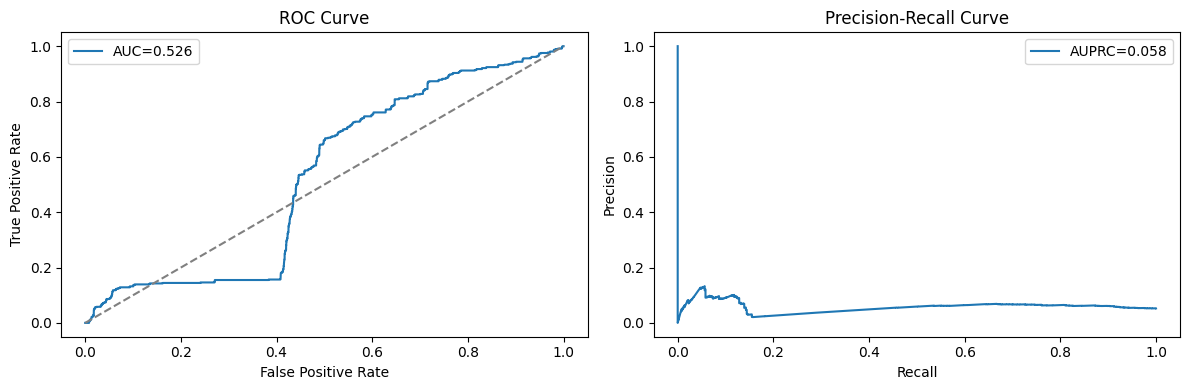

In [72]:
proba_test = model.predict_proba(X_test)[:, 1]

auc = roc_auc_score(y_test, proba_test)
auprc = average_precision_score(y_test, proba_test)

print("\n=== Test Metrics ===")
print(f"ROC AUC : {auc:.4f}")
print(f"AUPRC   : {auprc:.4f}")

# Pick a threshold (0.5 default). Often for imbalance you may tune it.
threshold = 0.50
yhat_test = (proba_test >= threshold).astype(int)

cm = confusion_matrix(y_test, yhat_test)
print("\nConfusion matrix (threshold = %.2f):\n%s" % (threshold, cm))
print("\nClassification report:\n", classification_report(y_test, yhat_test, digits=4))

# Plot ROC + PR curves
fpr, tpr, thresholds = roc_curve(y_test, proba_test)
prec, rec, _ = precision_recall_curve(y_test, proba_test)
j = tpr - fpr
best_idx = np.argmax(j)
thresh = thresholds[best_idx]
print(f"Best threshold by Youden's J: {thresh:.3f} (TPR={tpr[best_idx]:.3f}, FPR={fpr[best_idx]:.3f})")
fig, ax = plt.subplots(1, 2, figsize=(12, 4))

ax[0].plot(fpr, tpr, label=f"AUC={auc:.3f}")
ax[0].plot([0, 1], [0, 1], "--", color="gray")
ax[0].set_title("ROC Curve")
ax[0].set_xlabel("False Positive Rate")
ax[0].set_ylabel("True Positive Rate")
ax[0].legend()

ax[1].plot(rec, prec, label=f"AUPRC={auprc:.3f}")
ax[1].set_title("Precision-Recall Curve")
ax[1].set_xlabel("Recall")
ax[1].set_ylabel("Precision")
ax[1].legend()

plt.tight_layout()
plt.show()

In [57]:
import pandas as pd

w   = int(24)      # hours (rows if your data is hourly)
thr = int(19)
depeg_side = "both"  # "up", "down", or "both"
x = dataset["poolTick"].astype(float)

# ---- dynamic thresholds: rolling 30D quantiles (computed, but not used until full 30D) ----
upper = x.rolling("30D", min_periods=1).quantile(0.9975)
lower = x.rolling("30D", min_periods=1).quantile(0.0025)

# only allow dynamic rule once we have a full 30 days of history
start = dataset.index.min()
dyn_ok = pd.Series(
    dataset.index >= (start + pd.Timedelta(days=30)),
    index=dataset.index
)

# look strictly into (t, t+w]
x1     = x.shift(-1)
upper1 = upper.shift(-1)
lower1 = lower.shift(-1)

# validity must correspond to the *future* time (t+1) we are checking
dyn_ok1 = dyn_ok.shift(-1).fillna(False)

# optional: keep only one direction for the hard-threshold part
if depeg_side == "up":
    x1_hard = x1.clip(lower=0)
elif depeg_side == "down":
    x1_hard = x1.clip(upper=0)
else:
    x1_hard = x1

# ---- hard threshold condition in next w hours ----
future_max = x1_hard.iloc[::-1].rolling(w, min_periods=1).max().iloc[::-1]
future_min = x1_hard.iloc[::-1].rolling(w, min_periods=1).min().iloc[::-1]
hit_hard   = (future_max >= thr) | (future_min <= -thr)

# ---- dynamic quantile out-of-band condition in next w hours (disabled for first 30 days) ----
if depeg_side == "up":
    out_of_band = (x1 > upper1)
elif depeg_side == "down":
    out_of_band = (x1 < lower1)
else:
    out_of_band = (x1 > upper1) | (x1 < lower1)

# disable dynamic flags where the quantile window isn't complete (for the *checked future time*)
out_of_band = (out_of_band & dyn_ok1).fillna(False)

hit_dyn = out_of_band.iloc[::-1].rolling(w, min_periods=1).max().iloc[::-1].astype(bool)

# ---- final target: hard OR dynamic within next w hours ----
dataset["target"] = (hit_hard | hit_dyn).fillna(False).astype(int)

/tmp/ipykernel_183068/2760722591.py:25: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  dyn_ok1 = dyn_ok.shift(-1).fillna(False)


In [40]:

x = dataset["poolTick"].astype(float)

# Rolling 30D mean/std (uses time-based window because of DateTimeIndex)
mu  = x.rolling("30D", min_periods=1).mean()
sig = x.rolling("30D", min_periods=1).std(ddof=0)

z30 = (x - mu) / sig.replace(0, np.nan)   # avoid divide-by-zero
dataset["z30"] = z30

# Optional: don't use z-score until full 30D history exists
start = dataset.index.min()
z_ok = dataset.index >= (start + pd.Timedelta(days=30))
dataset.loc[~z_ok, "z30"] = np.nan

# Example band (choose k)
k = 3.0
dataset["z_depeg_flag"] = (dataset["z30"].abs() >= k).fillna(False).astype(int)

In [41]:
dataset.z_depeg_flag.value_counts()

z_depeg_flag
0    35306
1      698
Name: count, dtype: int64

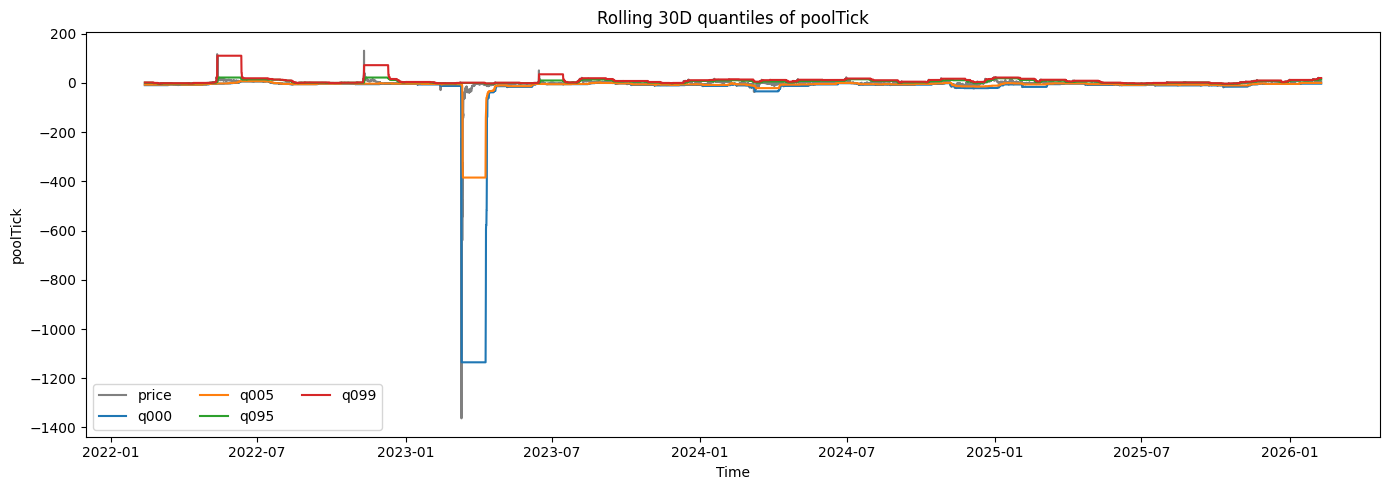

In [49]:
import pandas as pd
import matplotlib.pyplot as plt

# Assumes your dataframe is named `dataset`
# and has a datetime-like index OR a timestamp column you can set as index.

df = dataset.copy()

# If you have a time column, uncomment and set it:
# df["timestamp"] = pd.to_datetime(df["timestamp"])
# df = df.sort_values("timestamp").set_index("timestamp")

df = df.sort_index()  # if already time-indexed

price_col = "poolTick"

# Window: 30 days. For hourly data, you can also use window=30*24
# If your index is a DatetimeIndex, time-based windows like "30D" work well.
window = "30D"

# Rolling quantiles (example: 1%, 5%, 50%, 95%, 99%)
qs = [0.0025, 0.05, 0.95, 0.9975]
roll_q = pd.concat(
    {f"q{int(q*100):03d}": df[price_col].rolling(window).quantile(q) for q in qs},
    axis=1
)

# Plot
plot_win = 35000
fig, ax = plt.subplots(figsize=(14, 5))
ax.plot(df.iloc[-plot_win:].index, df.iloc[-plot_win:][price_col], color="grey", linewidth=1.5, label="price")

for c in roll_q.columns:
    ax.plot(roll_q.iloc[-plot_win:].index, roll_q.iloc[-plot_win:][c], linewidth=1.5, label=c)
ax.set_title(f"Rolling {window} quantiles of {price_col}")
ax.set_xlabel("Time")
ax.set_ylabel(price_col)
ax.legend(ncol=3)
plt.tight_layout()
plt.show()

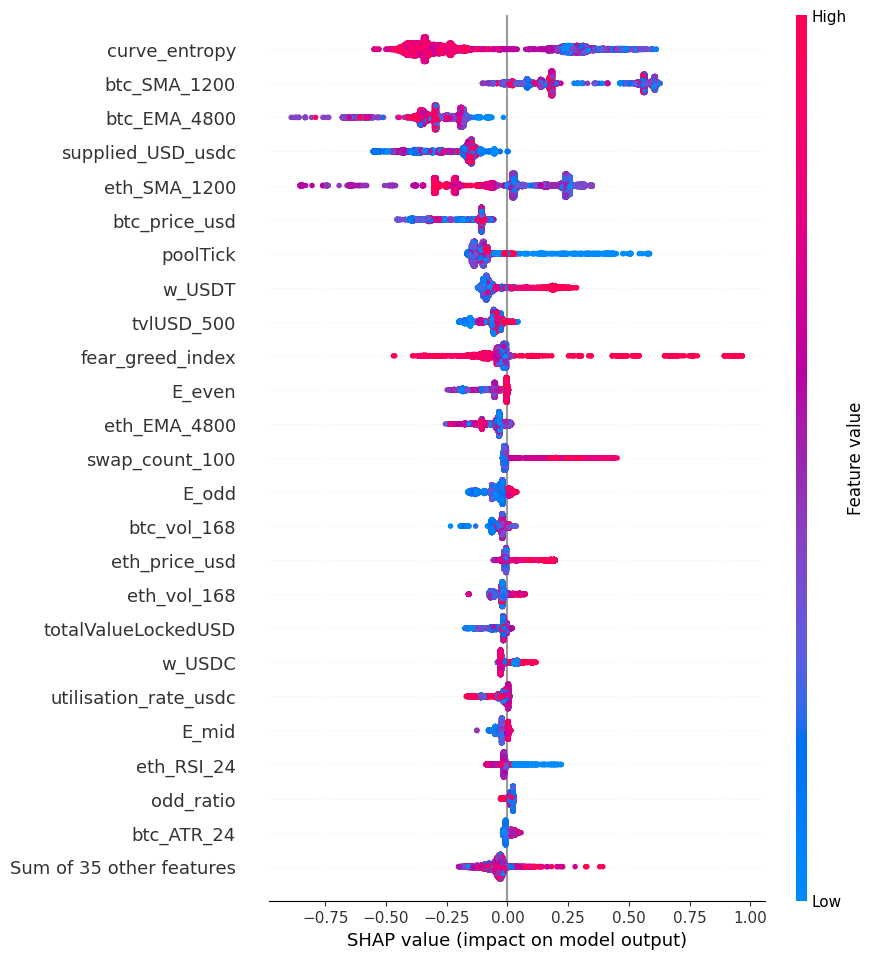

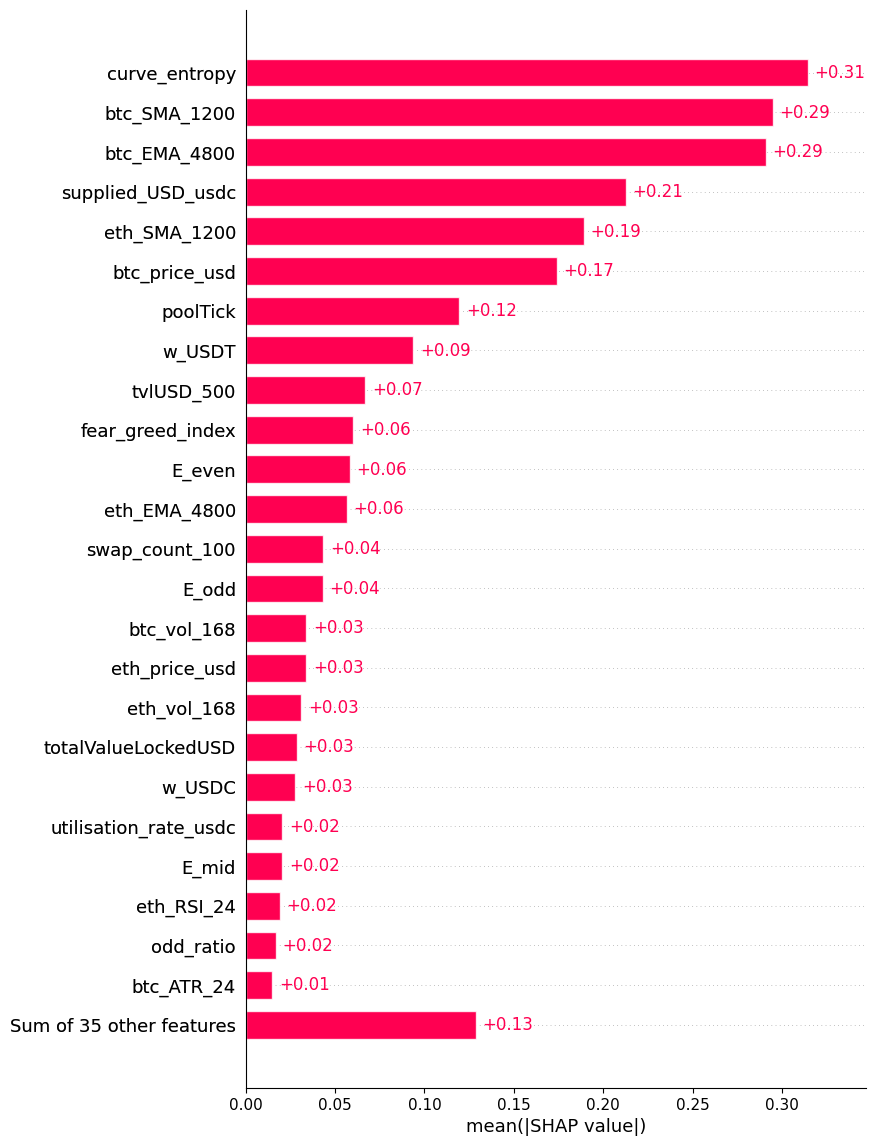

In [74]:
X_explain = X_test.copy()
# if len(X_explain) > 5000:
#     X_explain = X_explain.sample(5000, random_state=42)

explainer = shap.TreeExplainer(model)
shap_values = explainer(X_explain)  # shap.Explanation

# Global importance (beeswarm)
shap.plots.beeswarm(shap_values, max_display=25)

# Bar plot of mean(|SHAP|)
shap.plots.bar(shap_values, max_display=25)

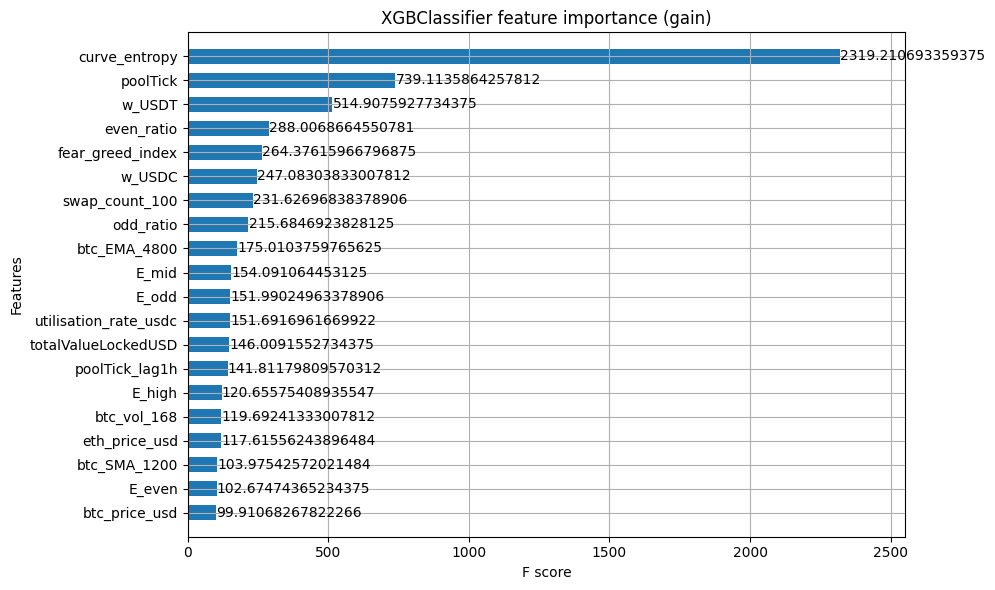

In [75]:
fig, ax = plt.subplots(figsize=(10,6))
plot_importance(
    model,
    importance_type="gain",   # "gain", "weight", "cover", "total_gain", "total_cover"
    max_num_features=20,
    height=.6,ax= ax
)
plt.title("XGBClassifier feature importance (gain)")
plt.tight_layout()
plt.show()

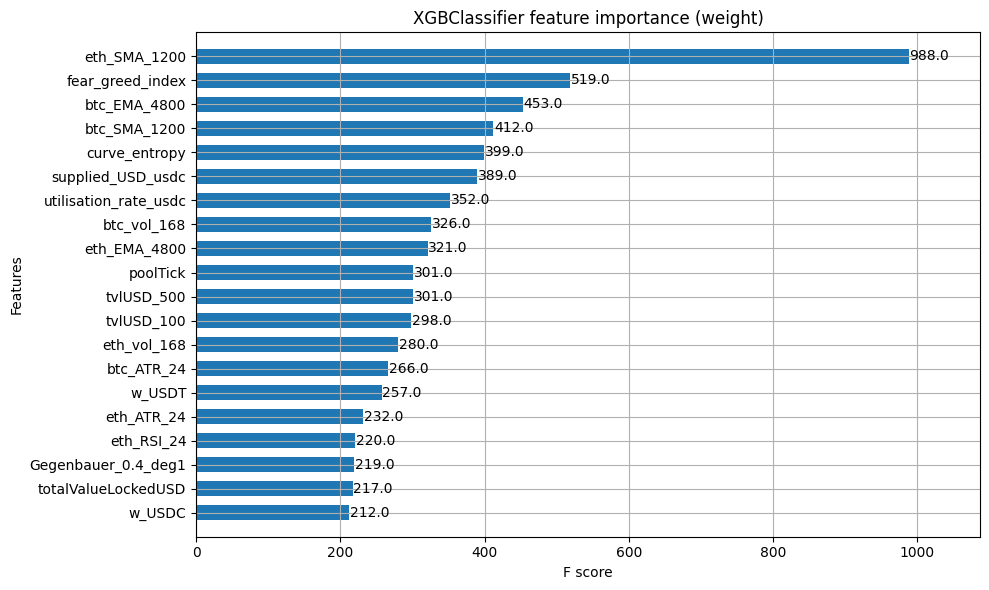

In [76]:
fig, ax = plt.subplots(figsize=(10,6))
plot_importance(
    model,
    importance_type="weight",   # "gain", "weight", "cover", "total_gain", "total_cover"
    max_num_features=20,
    height=.6,ax= ax
)
plt.title("XGBClassifier feature importance (weight)")
plt.tight_layout()
plt.show()

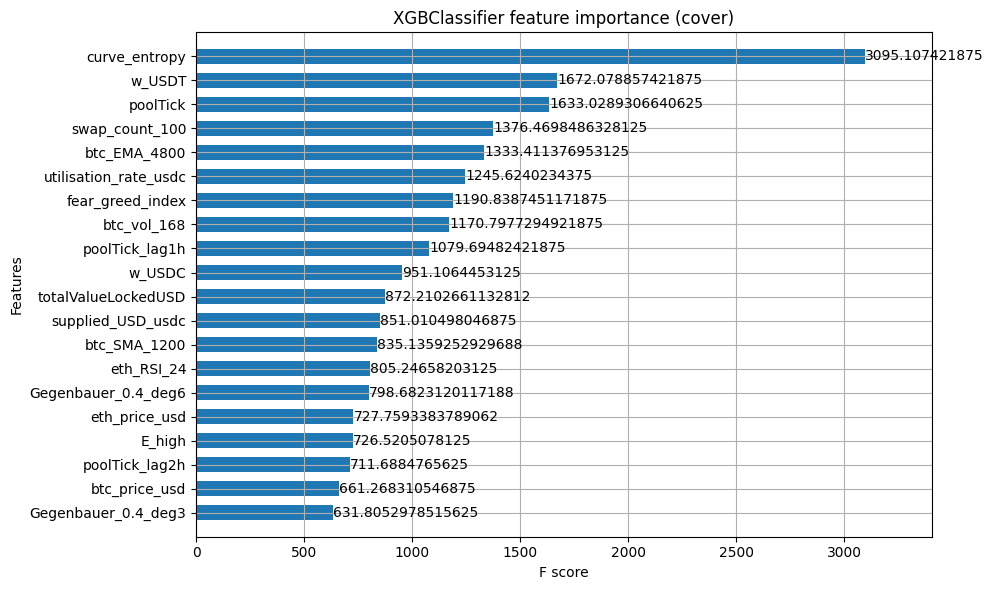

In [77]:
fig, ax = plt.subplots(figsize=(10,6))
plot_importance(
    model,
    importance_type="cover",   # "gain", "weight", "cover", "total_gain", "total_cover"
    max_num_features=20,
    height=.6,ax= ax
)
plt.title("XGBClassifier feature importance (cover)")
plt.tight_layout()
plt.show()